# Semantic Textual Similarity for Korean


## Import libraries and data

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 32.6 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 36.8 MB/s 
     |████████████████████████████████| 6.6 MB 52.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import torch
import numpy as np
import random
import os

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import BertTokenizer, BertModel

In [3]:
# seed
seed = 7777
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla T4
cuda


In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
cd "/content/drive/MyDrive/NLP_project"

/content/drive/MyDrive/NLP_project


In [7]:
_CUR_DIR = os.path.abspath(os.curdir)
print(f"My current directory : {_CUR_DIR}")
_DATA_DIR = os.path.join(_CUR_DIR, "klue-sts-v1.1")

My current directory : /content/drive/MyDrive/NLP_project


In [40]:
train = pd.read_json('./klue-sts-v1.1/klue-sts-v1.1_train.json')
test = pd.read_json('./klue-sts-v1.1/klue-sts-v1.1_dev.json')

In [9]:
print(train.shape, test.shape)
print(train.columns)
print(test.columns)

(11668, 6) (519, 6)
Index(['guid', 'source', 'sentence1', 'sentence2', 'labels', 'annotations'], dtype='object')
Index(['guid', 'source', 'sentence1', 'sentence2', 'labels', 'annotations'], dtype='object')


In [41]:
true = test['labels'].map(lambda x: x['binary-label'])

In [38]:
sentence = train.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
label = train['labels'].map(lambda x: round(x['real-label']))
train = pd.concat([sentence,label],axis=1)
train.columns = ['sentence','label']
sentence = test.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
label = test['labels'].map(lambda x: round(x['real-label']))
test = pd.concat([sentence,label],axis=1)
test.columns = ['sentence','label']

In [11]:
train.head()

,sentence,label
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다. [SEP] 숙박시설의 위...,4
1,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다. ...,0
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘. [SEP] ...,0
3,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...",1
4,"호스트의 답장이 늦으나, 개선될 것으로 보입니다. [SEP] 호스트 응답이 늦었지만...",5


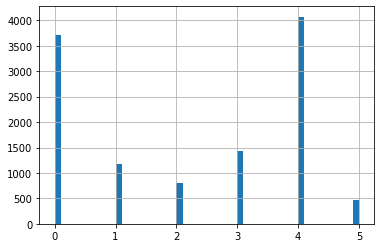

In [12]:
train['label'].hist(bins=50)

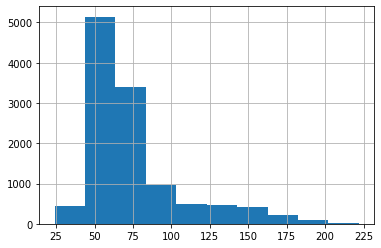

In [13]:
train['sentence'].map(lambda x: len(x)).hist()

## Data preprocess

In [14]:
# Custom Dataset
class CustomDataset(Dataset):
    """
    - input_data: list of string
    - target_data: list of int
    """
    
    def __init__(self, input_data:list, target_data:list) -> None:
        self.X = input_data
        self.Y = target_data
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [15]:
train_dataset = CustomDataset(train.sentence.to_list(), train.label.to_list())
test_dataset = CustomDataset(test.sentence.to_list(), test.label.to_list())
print(f"Train Dataset len: {len(train_dataset)}")
print(f"Train Dataset 1st element: {train_dataset[0]}")

print(f"Test Dataset len: {len(test_dataset)}")
print(f"Test Dataset 1st element: {test_dataset[0]}")

Train Dataset len: 11668
Train Dataset 1st element: ('숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다. [SEP] 숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.', 4)
Test Dataset len: 519
Test Dataset 1st element: ('무엇보다도 호스트분들이 너무 친절하셨습니다. [SEP] 무엇보다도, 호스트들은 매우 친절했습니다.', 5)


In [16]:
n_sample = train.shape[0]
n_train = int(n_sample*0.9)
n_valid = n_sample-n_train
train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_valid])

print(f"Train dataset len: {len(train_dataset)}")
print(f"Valid dataset len: {len(valid_dataset)}")

Train dataset len: 10501
Valid dataset len: 1167


In [17]:
# Custom collate_fn 
def custom_collate_fn(batch):
    """
    한 배치 내 문장들을 tokenizing 한 후 텐서로 변환함. 
    이때, dynamic padding (즉, 같은 배치 내 토큰의 개수가 동일할 수 있도록, 부족한 문장에 [PAD] 토큰을 추가하는 작업)을 적용
    
    한 배치 내 레이블(target)은 텐서화 함.
    
    - batch: list of tuples (input_data(string), target_data(int))
    """
    input_list, target_list = [], []

    tokenizer_bert = BertTokenizer.from_pretrained("klue/bert-base")
    
    for _input, _target in batch:
        input_list.append(_input)
        target_list.append(_target)
    
    tensorized_input = tokenizer_bert(
        input_list,
        add_special_tokens=True,
        padding="longest", # 배치내 가장 긴 문장을 기준으로 부족한 문장은 [PAD] 토큰을 추가
        truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
        max_length=512,
        return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
    )
    
    tensorized_label = torch.tensor(target_list)
    
    return tensorized_input, tensorized_label

In [18]:
# DataLoader 구현
train_batch_size = 32
valid_batch_size = 64

train_dataloader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    sampler = RandomSampler(train_dataset),
    collate_fn = custom_collate_fn
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = valid_batch_size,
    sampler = SequentialSampler(valid_dataset),
    collate_fn = custom_collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = valid_batch_size,
    sampler = SequentialSampler(test_dataset),
    collate_fn = custom_collate_fn
)
print(f"Train dataloader # steps: {len(train_dataloader)}")
print(f"Valid dataloader # steps: {len(valid_dataloader)}")
print(f"Test dataloader # steps: {len(test_dataloader)}")

Train dataloader # steps: 329
Valid dataloader # steps: 19
Test dataloader # steps: 9


## Model

In [19]:
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
from transformers import get_linear_schedule_with_warmup, get_constant_schedule

In [20]:
# Custom Classifer
class CustomClassifier(nn.Module):

    def __init__(self, hidden_size: int, n_label: int, freeze_base: bool = False):
        super(CustomClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("klue/bert-base")

        if freeze_base:
            for param in self.bert.parameters():
                param.requires_grad=False

        dropout_rate = 0.1
        linear_layer_hidden_size = 6

        self.classifier = nn.Sequential(
        nn.Linear(hidden_size, linear_layer_hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(linear_layer_hidden_size, n_label)
        )

    

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        last_hidden_states = outputs[0] # last hidden states (batch_size, sequence_len, hidden_size)
        cls_token_last_hidden_states = last_hidden_states[:,0,:] # (batch_size, first_token, hidden_size)

        logits = self.classifier(cls_token_last_hidden_states)

        return logits

In [21]:
def initializer(train_dataloader, epochs=2):
    """
    모델, 옵티마이저, 스케쥴러 초기화
    """
    
    model = CustomClassifier(hidden_size=768, n_label=6)

    optimizer = AdamW(
        model.parameters(), # update 대상 파라미터를 입력
        lr=2e-5,
        eps=1e-8
    )
    
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0, # 여기서는 warmup을 사용하지 않는다.
        num_training_steps = total_steps
    )

    return model, optimizer, scheduler

In [22]:
def save_checkpoint(path, model, optimizer, scheduler, epoch, loss):
    file_name = f'{path}/model.ckpt.{epoch}'
    
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}")

In [23]:
def validate(model, valid_dataloader):
   
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc= 0,0
        
    for step, batch in enumerate(valid_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
            
        # gradient 계산하지 않음
        with torch.no_grad():
            logits = model(**batch_input)
            
        # loss
        loss = loss_fct(logits, batch_label)
        total_loss += loss.item()
        
        # accuracy
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).flatten()
        acc = (preds == batch_label).cpu().numpy().mean()
        total_acc+=acc
    
    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)*100

    return total_loss, total_acc

In [24]:
def train_model(model, train_dataloader, valid_dataloader=None, epochs=2):
        
        # train_dataloaer 학습을 epochs만큼 반복
        for epoch in range(epochs):
            print(f"*****Epoch {epoch} Train Start*****")
            
            # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
            total_loss, batch_loss, batch_count = 0,0,0
        
            # model을 train 모드로 설정 & device 할당
            model.train()
            model.to(device)
            
            # data iterator를 돌면서 하나씩 학습
            for step, batch in enumerate(train_dataloader):
                batch_count+=1
                
                # tensor 연산 전, 각 tensor에 device 할당
                batch = tuple(item.to(device) for item in batch)
            
                batch_input, batch_label = batch
            
                # batch마다 모델이 갖고 있는 기존 gradient를 초기화
                model.zero_grad()
            
                # forward
                logits = model(**batch_input)
            
                # loss
                loss = loss_fct(logits, batch_label)
                batch_loss += loss.item()
                total_loss += loss.item()
            
                # backward -> 파라미터의 미분(gradient)를 자동으로 계산
                loss.backward()
                
                # gradient clipping 적용 
                clip_grad_norm_(model.parameters(), 1.0)
                
                # optimizer & scheduler 업데이트
                optimizer.step()
                scheduler.step()
                
                # 배치 10개씩 처리할 때마다 평균 loss와 lr를 출력
                if (step % 10 == 0 and step != 0):
                    learning_rate = optimizer.param_groups[0]['lr']
                    print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate}, Avg Loss : {batch_loss / batch_count:.4f}")

                    # reset 
                    batch_loss, batch_count = 0,0
            
            print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
            print(f"*****Epoch {epoch} Train Finish*****\n")
            
            if valid_dataloader is not None:
                print(f"*****Epoch {epoch} Valid Start*****")
                valid_loss, valid_acc = validate(model, valid_dataloader)
                print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.2f}")
                print(f"*****Epoch {epoch} Valid Finish*****\n")
            
            # checkpoint 저장
            save_checkpoint(".", model, optimizer, scheduler, epoch, total_loss/(step+1))
                
        print("Train Completed. End Program.")

In [25]:
loss_fct = CrossEntropyLoss()
epochs=4
model, optimizer, scheduler = initializer(train_dataloader, epochs)
train_model(model, train_dataloader, valid_dataloader, epochs)

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1316
*****Epoch 0 Train Start*****


Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Epoch: 0, Step : 10, LR : 1.9832826747720366e-05, Avg Loss : 1.5235
Epoch: 0, Step : 20, LR : 1.968085106382979e-05, Avg Loss : 1.5199
Epoch: 0, Step : 30, LR : 1.952887537993921e-05, Avg Loss : 1.3541
Epoch: 0, Step : 40, LR : 1.9376899696048635e-05, Avg Loss : 1.3596
Epoch: 0, Step : 50, LR : 1.922492401215806e-05, Avg Loss : 1.2796
Epoch: 0, Step : 60, LR : 1.9072948328267476e-05, Avg Loss : 1.0687
Epoch: 0, Step : 70, LR : 1.89209726443769e-05, Avg Loss : 1.2838
Epoch: 0, Step : 80, LR : 1.8768996960486324e-05, Avg Loss : 1.1977
Epoch: 0, Step : 90, LR : 1.8617021276595745e-05, Avg Loss : 1.2475
Epoch: 0, Step : 100, LR : 1.846504559270517e-05, Avg Loss : 1.2616
Epoch: 0, Step : 110, LR : 1.8313069908814593e-05, Avg Loss : 1.1735
Epoch: 0, Step : 120, LR : 1.8161094224924014e-05, Avg Loss : 1.1524
Epoch: 0, Step : 130, LR : 1.8009118541033438e-05, Avg Loss : 1.1101
Epoch: 0, Step : 140, LR : 1.785714285714286e-05, Avg Loss : 1.1105
Epoch: 0, Step : 150, LR : 1.770516717325228e-05, 

## Evaluation

In [27]:
best_epoch = input()
checkpoint = torch.load(f'model.ckpt.{best_epoch}')

1


In [28]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss'])

In [29]:
epochs=1
model, optimizer, scheduler = initializer(train_dataloader, epochs)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 329


In [30]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [31]:
def predict(model, test_dataloader):
    """
    test_dataloader의 label별 확률값과 실제 label 값을 반환
    """

    model.eval()
    model.to(device)

    all_logits = []
    all_labels = []

    for step, batch in enumerate(test_dataloader):
        print(f"{step}/{len(test_dataloader)}")
        
        batch_input, batch_label = batch
        
        batch_input = batch_input.to(device)
        
        with torch.no_grad():
            logits = model(**batch_input)
            all_logits.append(logits)
        all_labels.extend(batch_label)

    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    all_labels = np.array(all_labels)

    return probs, all_labels


In [ ]:
probs, labels = predict(model, test_dataloader)

In [34]:
probs

array([[0.10737468, 0.02572541, 0.04804959, 0.09529515, 0.6220278 ,
        0.10152733],
       [0.21584032, 0.13680871, 0.15153737, 0.05418287, 0.29019287,
        0.1514379 ],
       [0.20642097, 0.1230692 , 0.14830612, 0.12397683, 0.2583158 ,
        0.13991107],
       ...,
       [0.21546037, 0.14547428, 0.14627595, 0.02101867, 0.31597644,
        0.15579426],
       [0.21566342, 0.14506753, 0.14670524, 0.02224986, 0.31465083,
        0.1556631 ],
       [0.19859971, 0.11538442, 0.14318813, 0.16753906, 0.24309598,
        0.13219273]], dtype=float32)

In [35]:
labels

array([5, 1, 1, 4, 2, 1, 4, 1, 0, 2, 2, 3, 1, 2, 5, 4, 4, 1, 0, 1, 3, 3,
       5, 4, 0, 3, 3, 3, 1, 3, 0, 0, 1, 3, 5, 2, 2, 4, 5, 4, 2, 4, 1, 3,
       1, 4, 4, 5, 0, 4, 1, 4, 2, 1, 4, 1, 1, 0, 3, 3, 3, 1, 2, 1, 4, 2,
       1, 0, 5, 5, 0, 0, 4, 4, 2, 4, 0, 4, 3, 3, 4, 2, 4, 2, 3, 3, 4, 4,
       0, 3, 0, 4, 5, 2, 5, 4, 1, 2, 4, 2, 1, 4, 4, 2, 5, 3, 1, 3, 5, 3,
       1, 2, 3, 1, 1, 4, 2, 1, 4, 4, 4, 2, 1, 2, 5, 4, 0, 3, 2, 3, 4, 4,
       1, 3, 2, 3, 2, 5, 1, 2, 4, 4, 1, 2, 2, 4, 4, 4, 2, 5, 3, 2, 3, 0,
       4, 2, 2, 3, 1, 1, 2, 2, 3, 2, 2, 4, 0, 3, 1, 3, 4, 4, 5, 2, 2, 4,
       4, 3, 3, 2, 4, 5, 3, 2, 1, 0, 2, 1, 3, 3, 4, 5, 2, 4, 2, 3, 0, 2,
       3, 3, 1, 4, 4, 3, 1, 4, 0, 4, 4, 4, 0, 1, 2, 0, 3, 2, 3, 0, 5, 4,
       0, 0, 1, 2, 2, 3, 2, 3, 1, 2, 1, 2, 4, 1, 4, 1, 2, 4, 3, 4, 4, 3,
       1, 5, 0, 3, 4, 2, 4, 2, 2, 0, 1, 4, 4, 5, 1, 2, 3, 3, 2, 3, 1, 2,
       1, 2, 5, 5, 4, 4, 3, 2, 1, 3, 1, 0, 1, 1, 0, 3, 2, 4, 4, 1, 3, 1,
       0, 1, 1, 1, 3, 2, 5, 0, 4, 2, 4, 3, 2, 1, 5,

In [42]:
true

0      1
1      0
2      0
3      1
4      0
      ..
514    0
515    0
516    0
517    0
518    0
Name: labels, Length: 519, dtype: int64

In [43]:
from sklearn.metrics import f1_score
def get_f1(true, pred):
    return f1_score(true, pred)

In [47]:
get_f1(true, list(map(lambda x: 1 if x>=3 else 0, labels)))

0.9128630705394191